# Customer Churn Analysis

This notebook analyzes customer churn patterns in a telecom company dataset. We'll identify factors that contribute to customer churn and provide insights for reducing customer attrition.

## Objectives:
1. Analyze customer churn patterns
2. Identify key factors influencing churn
3. Provide data-driven insights for reducing churn rate

Let's begin by importing the necessary libraries and loading our dataset.

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set display options
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Data Loading and Initial Inspection

Let's load the telecom customer dataset and examine its structure.

In [24]:
# Load the dataset
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows
print("First few rows of the dataset:")
display(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
display(df.info())

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

First few rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-

None


Summary Statistics:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 2. Data Cleaning and Preprocessing

Now let's clean the data by:
1. Handling missing values
2. Correcting data types
3. Removing duplicates
4. Standardizing categorical variables

In [25]:
# Check for missing values
print("Missing values in each column:")
display(df.isnull().sum())

# Check for duplicate records
print("\nNumber of duplicate records:", df.duplicated().sum())

# Convert TotalCharges to numeric, handling any non-numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values in TotalCharges using loc
df.loc[df['TotalCharges'].isnull(), 'TotalCharges'] = df.loc[df['TotalCharges'].isnull(), 'MonthlyCharges'] * df.loc[df['TotalCharges'].isnull(), 'tenure']

# Convert binary categorical variables to numeric
df['Churn'] = (df['Churn'] == 'Yes').astype(int)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# Create binary flags for other categorical variables
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_columns:
    df[col] = (df[col] == 'Yes').astype(int)

print("\nUpdated data types:")
display(df.dtypes)

Missing values in each column:


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Number of duplicate records: 0

Updated data types:


customerID           object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

## 3. Feature Engineering

Let's create some new features that might help in our analysis:

In [26]:
# Create tenure-related features
df['tenure_years'] = df['tenure'] / 12
df['tenure_category'] = pd.cut(df['tenure'], 
                             bins=[0, 12, 24, 36, 48, 60, 72], 
                             labels=['0-1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5+ years'])

# Calculate average monthly charges
df['avg_monthly_charges'] = df['TotalCharges'] / df['tenure']
df.loc[df['tenure'] == 0, 'avg_monthly_charges'] = df.loc[df['tenure'] == 0, 'MonthlyCharges']

# Create feature for total services - more efficient approach
service_columns = {
    'PhoneService': 1,
    'InternetService': ['DSL', 'Fiber optic'],
    'OnlineSecurity': 'Yes',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes',
    'TechSupport': 'Yes',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes'
}

# Calculate total services
df['total_services'] = sum(
    (df[col] == val).astype(int) if isinstance(val, str)
    else df[col].isin(val).astype(int) if isinstance(val, list)
    else (df[col] == 1).astype(int)
    for col, val in service_columns.items()
)

# Display the new features
print("Sample of new features:")
display(df[['tenure_years', 'tenure_category', 'avg_monthly_charges', 'total_services']].head())

Sample of new features:


,tenure_years,tenure_category,avg_monthly_charges,total_services
0,0.083333,0-1 year,29.850000,2
1,2.833333,2-3 years,55.573529,4
2,0.166667,0-1 year,54.075000,4
3,3.750000,3-4 years,40.905556,4
4,0.166667,0-1 year,75.825000,2


## 4. Exploratory Data Analysis (EDA)

Let's analyze the patterns in our data, focusing on:
1. Overall churn rate
2. Relationship between categorical variables and churn
3. Relationship between numerical variables and churn
4. Correlation analysis

Overall Churn Rate: 26.54%


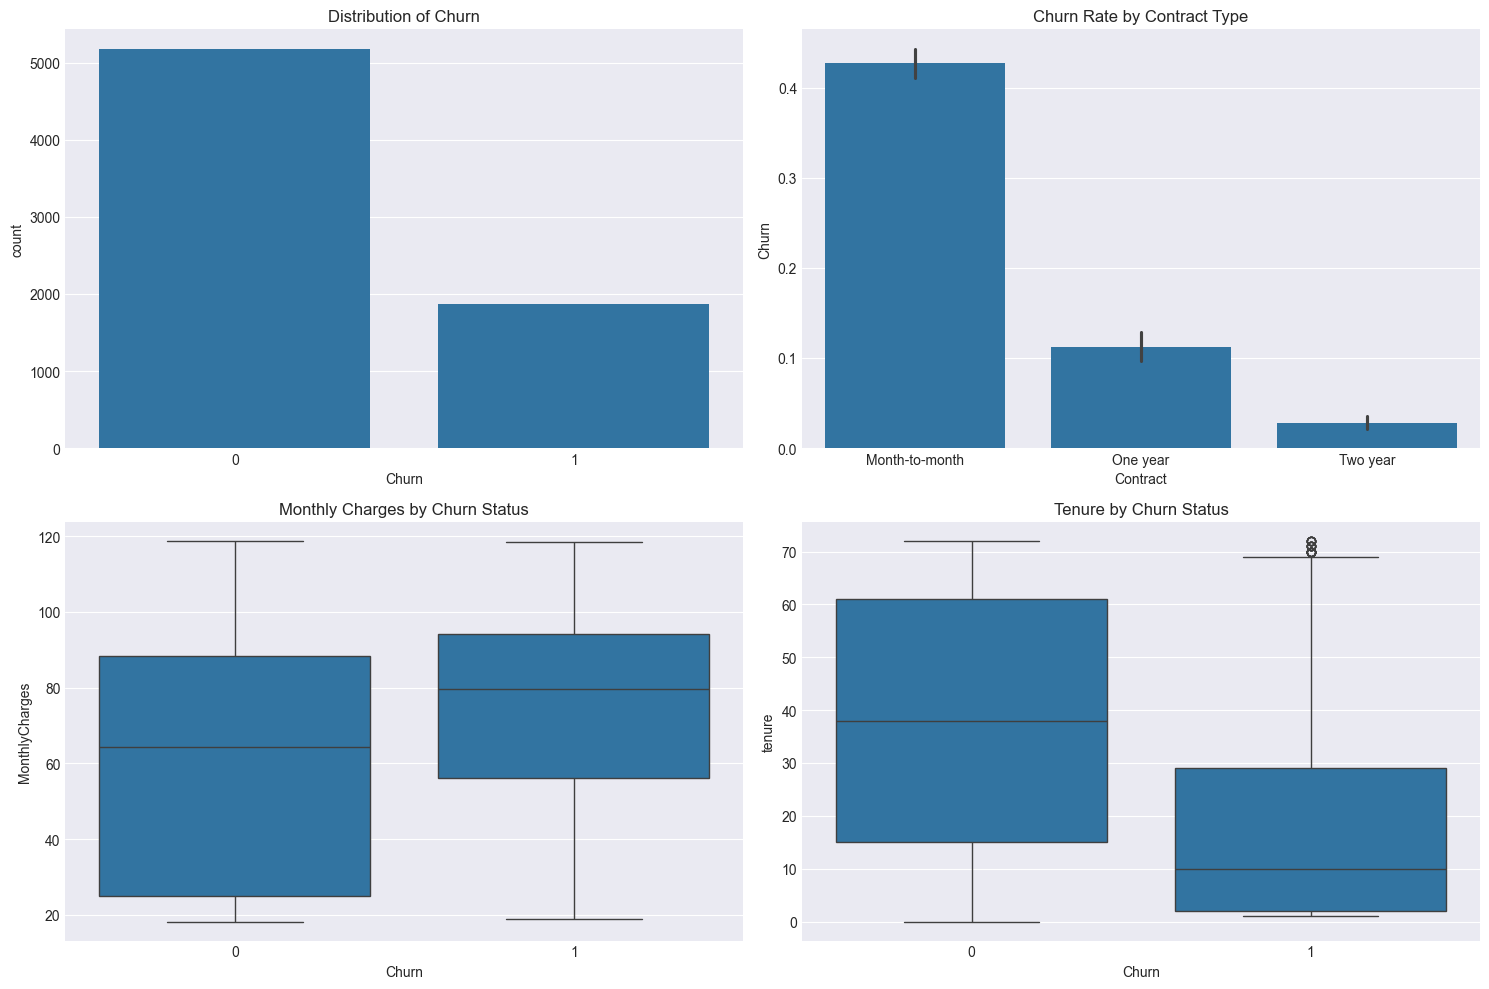

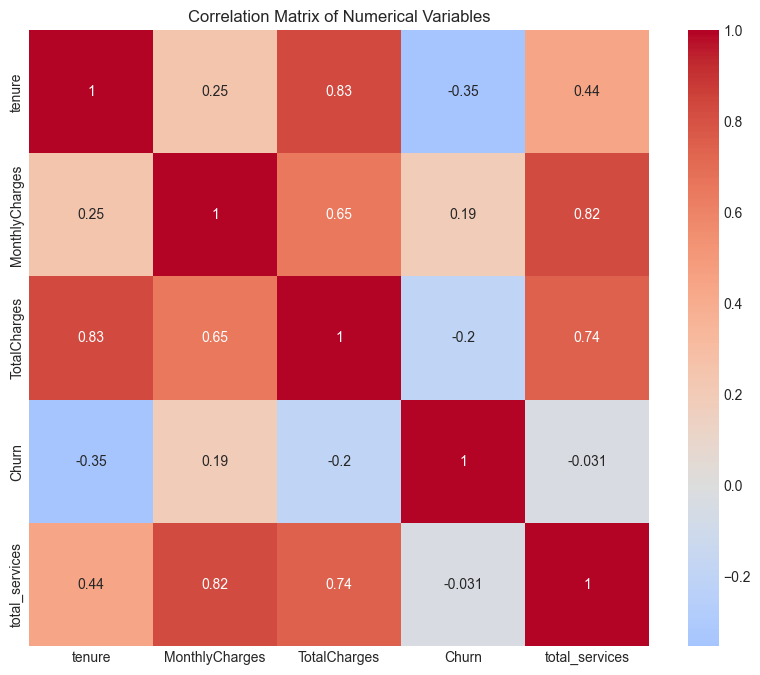

In [27]:
# Calculate overall churn rate
churn_rate = df['Churn'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%")

# Create a figure for multiple plots
plt.figure(figsize=(15, 10))

# Plot 1: Churn distribution
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Churn')

# Plot 2: Churn rate by contract type
plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Contract', y='Churn')
plt.title('Churn Rate by Contract Type')

# Plot 3: Monthly Charges distribution by Churn
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges by Churn Status')

# Plot 4: Tenure distribution by Churn
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title('Tenure by Churn Status')

plt.tight_layout()
plt.show()

# Create correlation matrix
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'total_services']
correlation_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## 5. Data Preprocessing for Machine Learning

We'll prepare our data for machine learning by:
1. Encoding categorical variables
2. Scaling numerical features
3. Creating the final feature matrix

In [28]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Identify numeric and categorical columns
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_years', 'avg_monthly_charges', 'total_services']
categorical_features = ['Contract', 'InternetService', 'MultipleLines', 'OnlineSecurity', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                       'StreamingMovies', 'PaymentMethod']

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare feature matrix X and target vector y
X = df[numeric_features + categorical_features]
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the preprocessing pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
onehot_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + onehot_features.tolist()

print("Data preprocessing completed.")
print(f"Training set shape: {X_train_processed.shape}")
print(f"Testing set shape: {X_test_processed.shape}")
print(f"Number of features: {len(feature_names)}")

Data preprocessing completed.
Training set shape: (5634, 27)
Testing set shape: (1409, 27)
Number of features: 27


## 6. Model Building and Evaluation

Let's build and evaluate two models:
1. Logistic Regression (baseline model)
2. Random Forest (more complex model)

Logistic Regression Results:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1036
           1       0.67      0.59      0.63       373

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.81      0.81      0.81      1409


Confusion Matrix:


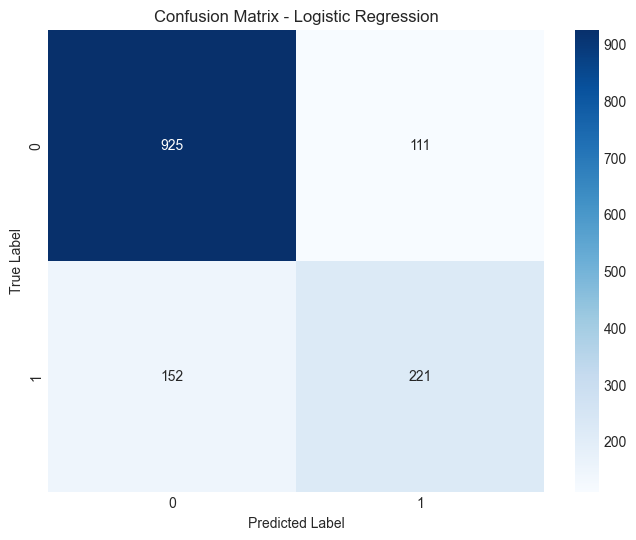


Random Forest Results:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1036
           1       0.63      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409


Confusion Matrix:


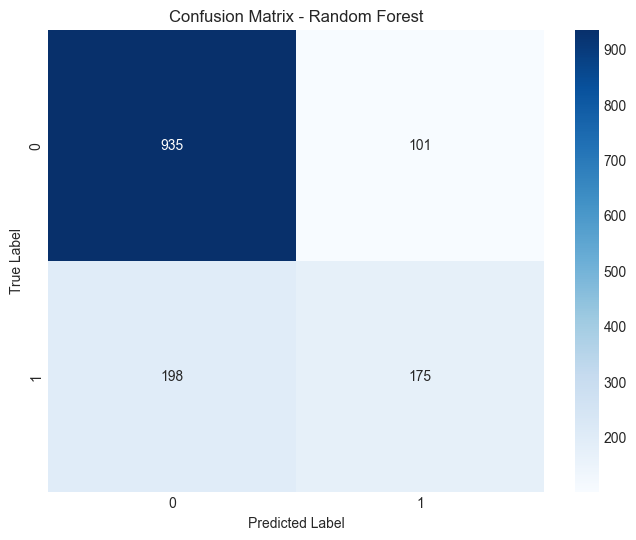

In [29]:
# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_processed, y_train)
lr_pred = lr_model.predict(X_test_processed)

print("Logistic Regression Results:")
print("-" * 30)
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)
rf_pred = rf_model.predict(X_test_processed)

print("\nRandom Forest Results:")
print("-" * 30)
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 7. Feature Importance Analysis

Let's analyze which features are most important in predicting customer churn:

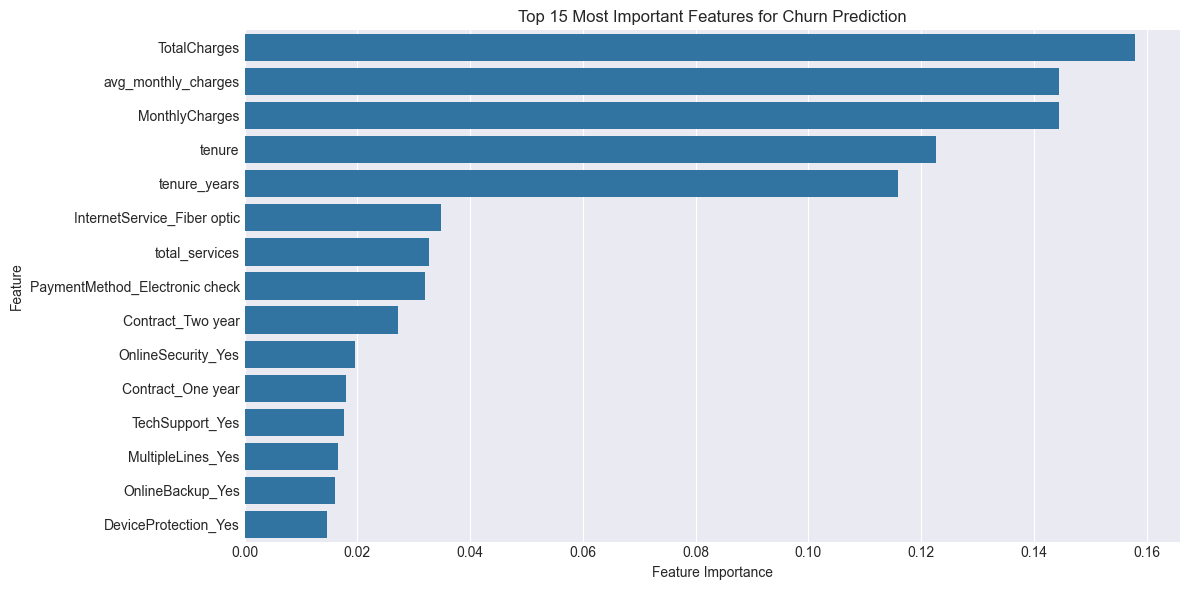


Top 10 Most Important Features:
                           feature  importance
2                     TotalCharges    0.157996
4              avg_monthly_charges    0.144474
1                   MonthlyCharges    0.144456
0                           tenure    0.122652
3                     tenure_years    0.115914
8      InternetService_Fiber optic    0.034927
5                   total_services    0.032634
25  PaymentMethod_Electronic check    0.032044
7                Contract_Two year    0.027249
13              OnlineSecurity_Yes    0.019557

Top 10 Features with Highest Odds Ratios (Logistic Regression):
                           feature  odds_ratio
8      InternetService_Fiber optic    2.966274
2                     TotalCharges    1.982485
10  MultipleLines_No phone service    1.621016
23             StreamingMovies_Yes    1.438832
25  PaymentMethod_Electronic check    1.418472
11               MultipleLines_Yes    1.376583
21                 StreamingTV_Yes    1.304808
5        

In [30]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features for Churn Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Calculate odds ratios for Logistic Regression
lr_odds_ratios = pd.DataFrame({
    'feature': feature_names,
    'odds_ratio': np.exp(lr_model.coef_[0])
})
lr_odds_ratios = lr_odds_ratios.sort_values('odds_ratio', ascending=False)

print("\nTop 10 Features with Highest Odds Ratios (Logistic Regression):")
print(lr_odds_ratios.head(10))

## 8. Advanced Analysis and Insights

### 8.1 Customer Segmentation and Detailed Relationships
Let's analyze the relationships between different features and create customer segments:

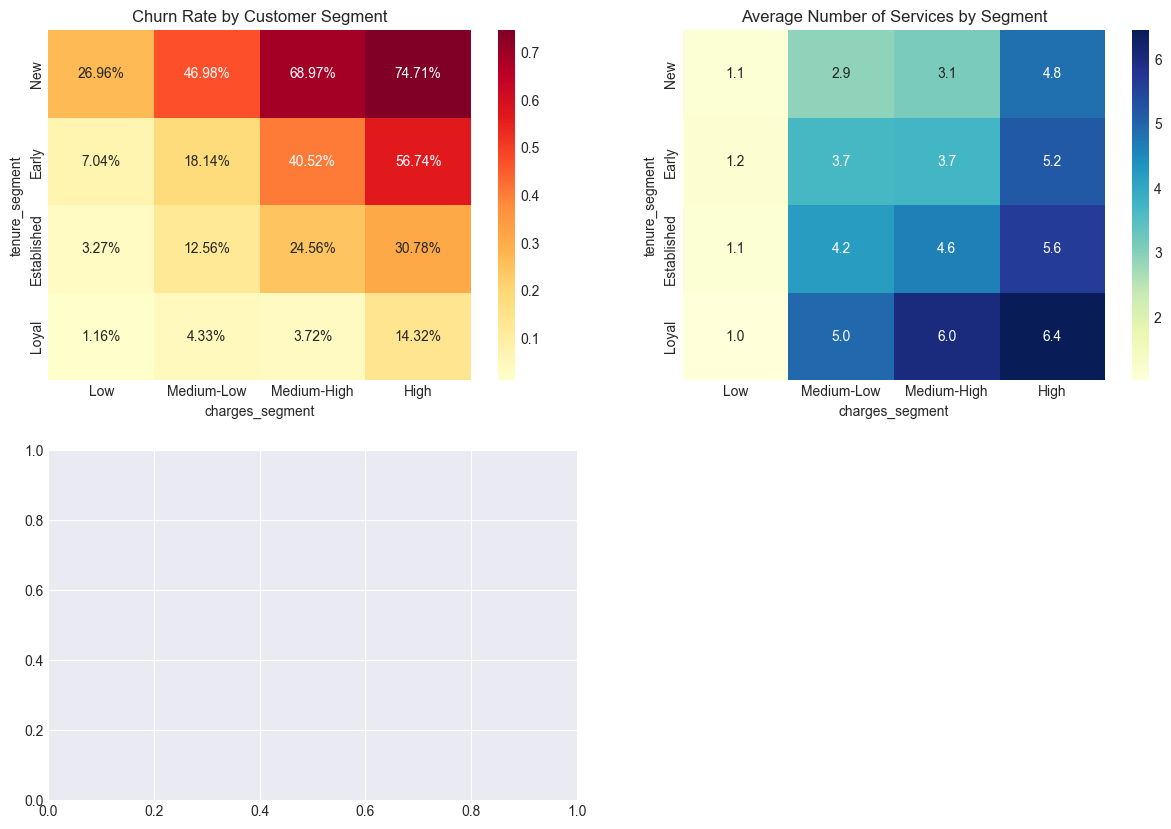

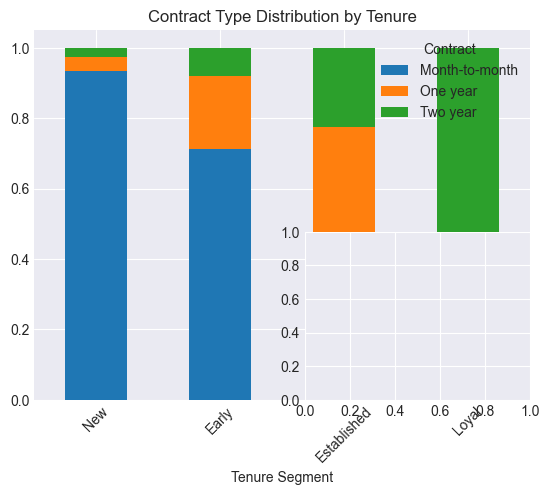

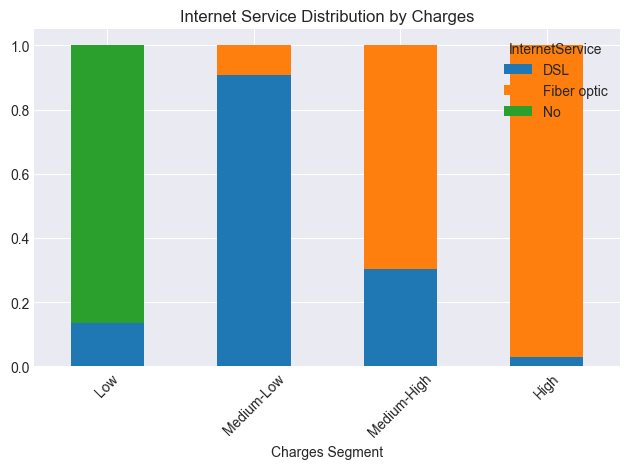


Detailed Segment Analysis:


Churn       MonthlyCharges total_services
                               count  mean           mean           mean
tenure_segment charges_segment                                          
New            Low               549  0.27          22.06           1.14
               Medium-Low        613  0.47          54.99           2.92
               Medium-High       522  0.69          78.96           3.10
               High              170  0.75          96.03           4.84
Early          Low               469  0.07          22.22           1.15
               Medium-Low        463  0.18          55.13           3.68
               Medium-High       464  0.41          80.77           3.71
               High              319  0.57          97.68           5.15
Established    Low               398  0.03          22.31           1.14
               Medium-Low        390  0.13          56.20           4.21
               Medium-High       395  0.25          80.58           4.64
               High              536  0.31         100.25           5.63
Loyal          Low               346  0.01          22.42           1.02
               Medium-Low        300  0.04          57.55           4.95
               Medium-High       376  0.04          81.44           6.02
               High              733  0.14         103.90           6.44

In [31]:
# Create customer segments based on tenure and monthly charges
df['tenure_segment'] = pd.qcut(df['tenure'], q=4, labels=['New', 'Early', 'Established', 'Loyal'])
df['charges_segment'] = pd.qcut(df['MonthlyCharges'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Create detailed segment analysis
segment_analysis = df.groupby(['tenure_segment', 'charges_segment']).agg({
    'Churn': ['count', 'mean'],
    'MonthlyCharges': 'mean',
    'total_services': 'mean'
}).round(2)

# Visualize churn rate by segments
plt.figure(figsize=(15, 10))

# Plot 1: Churn rate by tenure and charges segments
plt.subplot(2, 2, 1)
churn_by_segment = df.groupby(['tenure_segment', 'charges_segment'])['Churn'].mean().unstack()
sns.heatmap(churn_by_segment, annot=True, fmt='.2%', cmap='YlOrRd')
plt.title('Churn Rate by Customer Segment')

# Plot 2: Average services by tenure and charges segments
plt.subplot(2, 2, 2)
services_by_segment = df.groupby(['tenure_segment', 'charges_segment'])['total_services'].mean().unstack()
sns.heatmap(services_by_segment, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Average Number of Services by Segment')

# Plot 3: Contract type distribution by tenure segment
plt.subplot(2, 2, 3)
contract_by_tenure = pd.crosstab(df['tenure_segment'], df['Contract'], normalize='index')
contract_by_tenure.plot(kind='bar', stacked=True)
plt.title('Contract Type Distribution by Tenure')
plt.xlabel('Tenure Segment')
plt.xticks(rotation=45)

# Plot 4: Internet Service distribution by charges segment
plt.subplot(2, 2, 4)
internet_by_charges = pd.crosstab(df['charges_segment'], df['InternetService'], normalize='index')
internet_by_charges.plot(kind='bar', stacked=True)
plt.title('Internet Service Distribution by Charges')
plt.xlabel('Charges Segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Display segment analysis
print("\nDetailed Segment Analysis:")
display(segment_analysis)

### 8.2 Advanced Model Implementation
Let's implement XGBoost and perform hyperparameter tuning to improve our predictions:

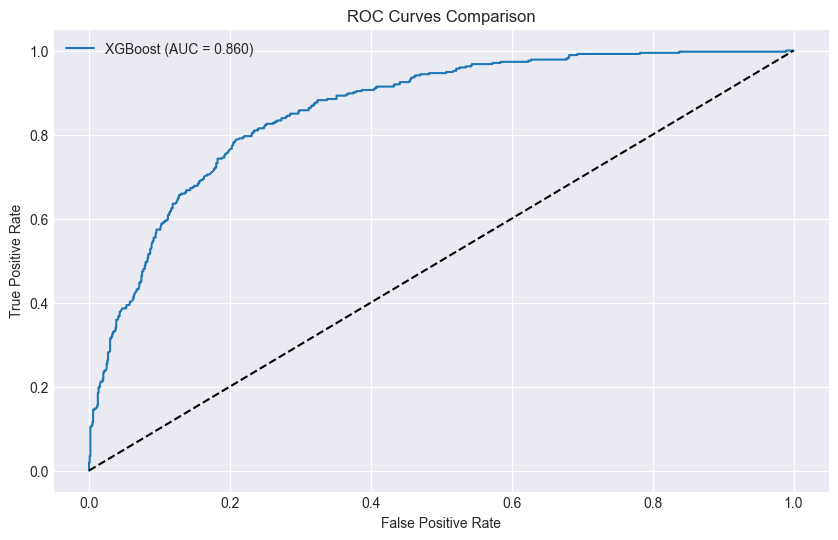

XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.55      0.61       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.81      0.81      1409



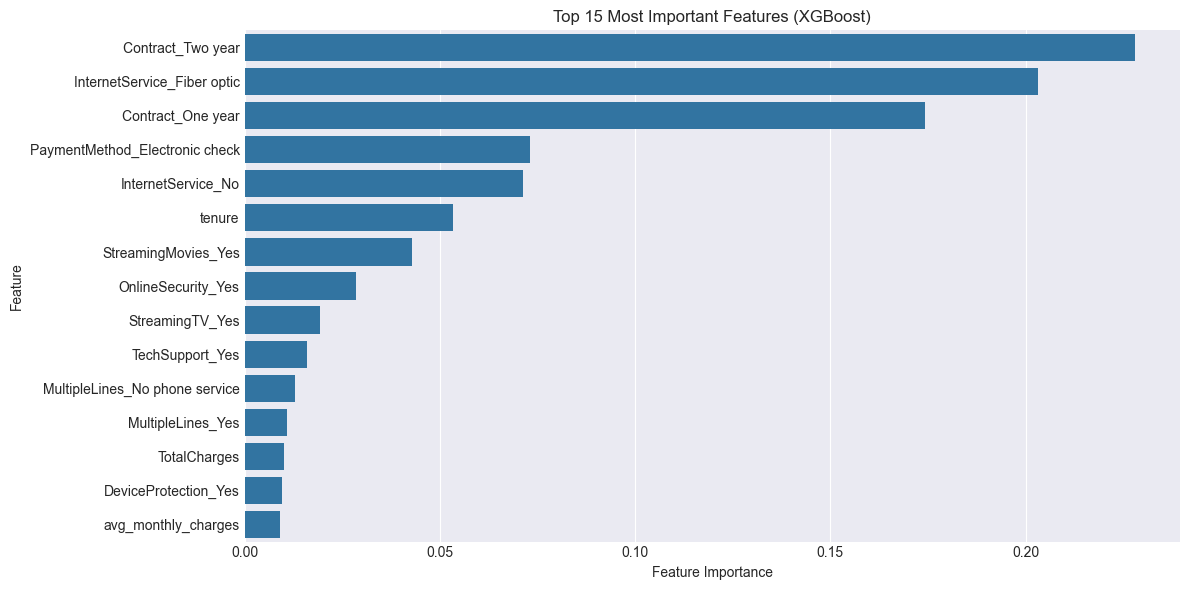

In [32]:
# Import additional libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_processed, y_train)

# Make predictions
xgb_pred = grid_search.predict(X_test_processed)
xgb_pred_proba = grid_search.predict_proba(X_test_processed)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, xgb_pred_proba)

# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# Print results
print("XGBoost Best Parameters:", grid_search.best_params_)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

# Get feature importance from XGBoost
xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': grid_search.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

# Plot XGBoost feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=xgb_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 8.3 Detailed Business Recommendations

Based on our advanced analysis, let's calculate the potential impact of our recommendations and provide specific action items:

In [33]:
# Calculate potential financial impact
avg_customer_lifetime = df['tenure'].mean()
avg_monthly_revenue = df['MonthlyCharges'].mean()
total_customers = len(df)
current_churn_rate = df['Churn'].mean()

# Calculate current metrics
current_yearly_revenue = total_customers * avg_monthly_revenue * 12
yearly_lost_customers = total_customers * current_churn_rate
yearly_lost_revenue = yearly_lost_customers * avg_monthly_revenue * avg_customer_lifetime

# Calculate potential improvements
target_churn_reduction = 0.05  # 5% reduction in churn rate
improved_yearly_lost_customers = total_customers * (current_churn_rate - target_churn_reduction)
improved_yearly_lost_revenue = improved_yearly_lost_customers * avg_monthly_revenue * avg_customer_lifetime
potential_savings = yearly_lost_revenue - improved_yearly_lost_revenue

# Identify high-risk segments
high_risk_segments = df.groupby(['tenure_segment', 'charges_segment']).agg({
    'Churn': ['count', 'mean'],
    'MonthlyCharges': 'sum'
}).sort_values(('Churn', 'mean'), ascending=False)

# Print financial analysis
print("Financial Impact Analysis:")
print("-" * 50)
print(f"Current Annual Revenue: ${current_yearly_revenue:,.2f}")
print(f"Current Annual Lost Revenue due to Churn: ${yearly_lost_revenue:,.2f}")
print(f"Potential Annual Savings with {target_churn_reduction*100}% Churn Reduction: ${potential_savings:,.2f}")

print("\nHigh-Risk Segment Analysis:")
print("-" * 50)
display(high_risk_segments.head())

Financial Impact Analysis:
--------------------------------------------------
Current Annual Revenue: $5,473,399.20
Current Annual Lost Revenue due to Churn: $3,918,190.99
Potential Annual Savings with 5.0% Churn Reduction: $738,250.91

High-Risk Segment Analysis:
--------------------------------------------------


Churn           MonthlyCharges
                               count      mean            sum
tenure_segment charges_segment                               
New            High              170  0.747059        16325.0
               Medium-High       522  0.689655        41218.5
Early          High              319  0.567398        31160.7
New            Medium-Low        613  0.469821        33710.3
Early          Medium-High       464  0.405172        37478.7

## 9. Additional Analysis and Visualizations

Let's create some additional visualizations to better understand customer behavior patterns:

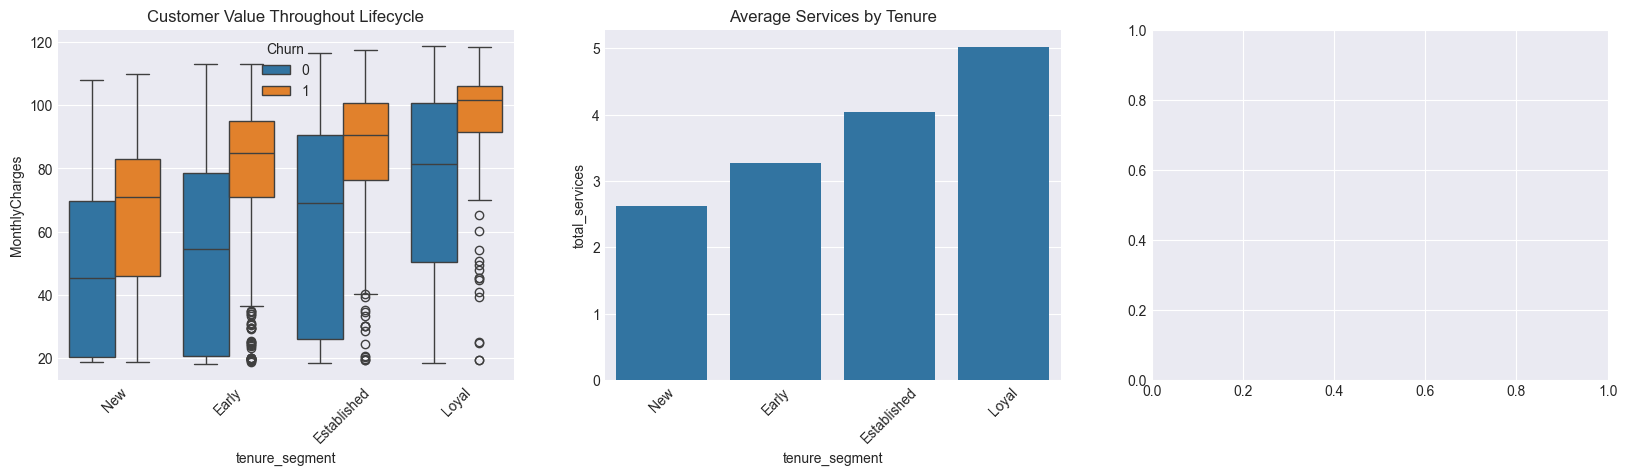

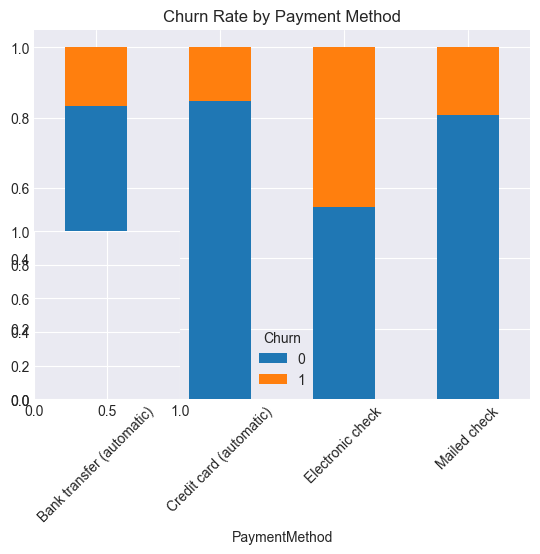

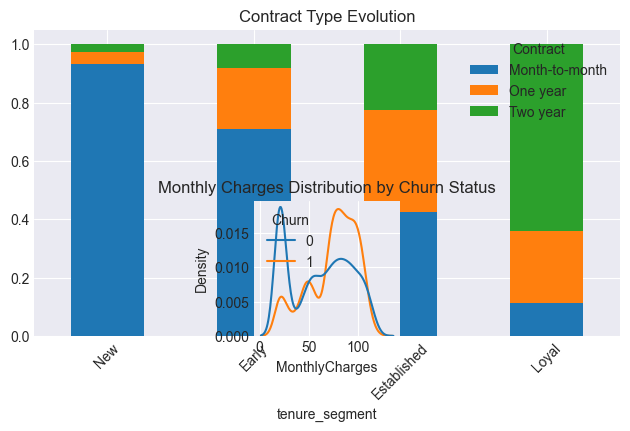


Key Business Metrics:
--------------------------------------------------
Average Customer Lifetime Value: $2096.41
Average Monthly Revenue per User: $64.76
Service Adoption Rate: 3.7 services per customer
High-Value Customer Retention Rate: 67.1%


In [34]:
# Create a comprehensive visualization of customer lifecycle
plt.figure(figsize=(20, 10))

# Plot 1: Customer Lifecycle Value
plt.subplot(2, 3, 1)
sns.boxplot(x='tenure_segment', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Customer Value Throughout Lifecycle')
plt.xticks(rotation=45)

# Plot 2: Service Adoption Patterns
plt.subplot(2, 3, 2)
service_data = df.groupby('tenure_segment')['total_services'].mean().reset_index()
sns.barplot(data=service_data, x='tenure_segment', y='total_services')
plt.title('Average Services by Tenure')
plt.xticks(rotation=45)

# Plot 3: Payment Patterns
plt.subplot(2, 3, 3)
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index')
payment_churn.plot(kind='bar', stacked=True)
plt.title('Churn Rate by Payment Method')
plt.xticks(rotation=45)

# Plot 4: Contract Evolution
plt.subplot(2, 3, 4)
contract_tenure = pd.crosstab(df['tenure_segment'], df['Contract'], normalize='index')
contract_tenure.plot(kind='bar', stacked=True)
plt.title('Contract Type Evolution')
plt.xticks(rotation=45)

# Plot 5: Monthly Charges Distribution
plt.subplot(2, 3, 5)
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', common_norm=False)
plt.title('Monthly Charges Distribution by Churn Status')

plt.tight_layout()
plt.show()

# Calculate and display key metrics
print("\nKey Business Metrics:")
print("-" * 50)
print(f"Average Customer Lifetime Value: ${df['MonthlyCharges'].mean() * df['tenure'].mean():.2f}")
print(f"Average Monthly Revenue per User: ${df['MonthlyCharges'].mean():.2f}")
print(f"Service Adoption Rate: {df['total_services'].mean():.1f} services per customer")
print(f"High-Value Customer Retention Rate: {1 - df[df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)]['Churn'].mean():.1%}")